In [143]:
# Deepfake Voice Detection System using Support Vector Machines (SVM)

# Cell 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import librosa
import librosa.display
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Audio processing libraries
import soundfile as sf
from scipy import signal
from scipy.stats import skew, kurtosis
import pickle

print("All libraries imported successfully!")
print("Available audio files will be processed for deepfake detection")

All libraries imported successfully!
Available audio files will be processed for deepfake detection


In [ ]:
# Configuration and Constants

SAMPLE_RATE = 22050
DURATION = 5.0
N_MFCC = 13
N_CHROMA = 12
N_MEL = 128
HOP_LENGTH = 512
N_FFT = 2048
RANDOM_STATE = 42

# GBAD Dataset paths
GBAD_BASE_PATH = "GBAD_Dataset"

TRAIN_REAL_PATH = os.path.join(GBAD_BASE_PATH, "01_Training", "REAL")
TRAIN_FAKE_PATH = os.path.join(GBAD_BASE_PATH, "01_Training", "FAKE")

VAL_REAL_PATH = os.path.join(GBAD_BASE_PATH, "02_Validation", "REAL")
VAL_FAKE_PATH = os.path.join(GBAD_BASE_PATH, "02_Validation", "FAKE")

TEST_REAL_PATH = os.path.join(GBAD_BASE_PATH, "03_Testing", "REAL")
TEST_FAKE_PATH = os.path.join(GBAD_BASE_PATH, "03_Testing", "FAKE")

# ✅ Debug: check if paths exist
for label, path in [
    ("TRAIN_REAL_PATH", TRAIN_REAL_PATH),
    ("TRAIN_FAKE_PATH", TRAIN_FAKE_PATH),
    ("VAL_REAL_PATH", VAL_REAL_PATH),
    ("VAL_FAKE_PATH", VAL_FAKE_PATH),
    ("TEST_REAL_PATH", TEST_REAL_PATH),
    ("TEST_FAKE_PATH", TEST_FAKE_PATH),
]:
    print(f"{label} exists: {os.path.exists(path)} — {path}")



TRAIN_REAL_PATH exists: True — GBAD_Dataset\01_Training\REAL
TRAIN_FAKE_PATH exists: True — GBAD_Dataset\01_Training\FAKE
VAL_REAL_PATH exists: True — GBAD_Dataset\02_Validation\REAL
VAL_FAKE_PATH exists: True — GBAD_Dataset\02_Validation\FAKE
TEST_REAL_PATH exists: True — GBAD_Dataset\03_Testing\REAL
TEST_FAKE_PATH exists: True — GBAD_Dataset\03_Testing\FAKE

Listing contents of dataset base path:
['01_Training', '02_Validation', '03_Testing']

Listing contents of training/REAL:
['1-FEMALE-REAL.wav', '10-FEMALE-REAL.wav', '100-FEMALE-REAL.wav', '101-FEMALE-REAL.wav', '102-FEMALE-REAL.wav', '103-FEMALE-REAL.wav', '104-FEMALE-REAL.wav', '105-FEMALE-REAL.wav', '106-FEMALE-REAL.wav', '107-FEMALE-REAL.wav', '108-FEMALE-REAL.wav', '109-FEMALE-REAL.wav', '11-FEMALE-REAL.wav', '110-FEMALE-REAL.wav', '111-FEMALE-REAL.wav', '112-FEMALE-REAL.wav', '113-FEMALE-REAL.wav', '114-FEMALE-REAL.wav', '115-FEMALE-REAL.wav', '116-FEMALE-REAL.wav', '117-FEMALE-REAL.wav', '118-FEMALE-REAL.wav', '119-FEMALE-

In [145]:
# Cell 3: Audio Feature Extraction Functions
def extract_mfcc_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract MFCC features from audio file"""
    try:
        # Load audio file
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)
        
        # Statistical features from MFCC
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)
        mfcc_skew = skew(mfccs, axis=1)
        mfcc_kurtosis = kurtosis(mfccs, axis=1)
        
        return np.concatenate([mfcc_mean, mfcc_std, mfcc_skew, mfcc_kurtosis])
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_chroma_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract Chroma features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=HOP_LENGTH)
        
        # Statistical features from chroma
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        return np.concatenate([chroma_mean, chroma_std])
    
    except Exception as e:
        print(f"Error processing chroma for {audio_path}: {e}")
        return None

def extract_mel_spectrogram_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract Mel spectrogram features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MEL, hop_length=HOP_LENGTH)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Statistical features from mel spectrogram
        mel_mean = np.mean(mel_spec_db, axis=1)
        mel_std = np.std(mel_spec_db, axis=1)
        
        return np.concatenate([mel_mean, mel_std])
    
    except Exception as e:
        print(f"Error processing mel spectrogram for {audio_path}: {e}")
        return None

def extract_spectral_features(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION):
    """Extract spectral features from audio file"""
    try:
        audio, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=HOP_LENGTH)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=HOP_LENGTH)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, hop_length=HOP_LENGTH)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio, hop_length=HOP_LENGTH)
        
        # Statistical measures
        features = [
            np.mean(spectral_centroid),
            np.std(spectral_centroid),
            np.mean(spectral_rolloff),
            np.std(spectral_rolloff),
            np.mean(spectral_bandwidth),
            np.std(spectral_bandwidth),
            np.mean(zero_crossing_rate),
            np.std(zero_crossing_rate)
        ]
        
        return np.array(features)
    
    except Exception as e:
        print(f"Error processing spectral features for {audio_path}: {e}")
        return None

def extract_all_features(audio_path):
    """Extract all audio features and combine them"""
    mfcc_features = extract_mfcc_features(audio_path)
    chroma_features = extract_chroma_features(audio_path)
    mel_features = extract_mel_spectrogram_features(audio_path)
    spectral_features = extract_spectral_features(audio_path)
    
    if all(f is not None for f in [mfcc_features, chroma_features, mel_features, spectral_features]):
        return np.concatenate([mfcc_features, chroma_features, mel_features, spectral_features])
    else:
        print(f"Skipping file due to failed feature extraction: {audio_path}")
        return None

print("Feature extraction functions defined successfully!")

Feature extraction functions defined successfully!


In [146]:
# Cell 4: GBAD Dataset Loading Functions
def load_gbad_split(real_path, fake_path, split_name):
    features = []
    labels = []
    file_paths = []

    if os.path.exists(real_path):
        real_files = glob.glob(os.path.join(real_path, "*.wav")) + glob.glob(os.path.join(real_path, "*.mp3"))
        print(f"[{split_name}] Found {len(real_files)} real audio files")
        for file_path in real_files:
            feature_vector = extract_all_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(0)
                file_paths.append(file_path)
    else:
        print(f"[{split_name}] ❌ Real path not found: {real_path}")

    if os.path.exists(fake_path):
        fake_files = glob.glob(os.path.join(fake_path, "*.wav")) + glob.glob(os.path.join(fake_path, "*.mp3"))
        print(f"[{split_name}] Found {len(fake_files)} fake audio files")
        for file_path in fake_files:
            feature_vector = extract_all_features(file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(1)
                file_paths.append(file_path)
    else:
        print(f"[{split_name}] ❌ Fake path not found: {fake_path}")

    print(f"[{split_name}] ✅ Total features extracted: {len(features)}")
    return np.array(features), np.array(labels), file_paths

def load_gbad_dataset():
    """Load the complete GBAD dataset"""
    print("Loading GBAD Dataset...")
    
    # Load training data
    X_train, y_train, train_files = load_gbad_split(TRAIN_REAL_PATH, TRAIN_FAKE_PATH, "Training")
    
    # Load validation data
    X_val, y_val, val_files = load_gbad_split(VAL_REAL_PATH, VAL_FAKE_PATH, "Validation")
    
    # Load testing data
    X_test, y_test, test_files = load_gbad_split(TEST_REAL_PATH, TEST_FAKE_PATH, "Testing")
    
    return (X_train, y_train, train_files), (X_val, y_val, val_files), (X_test, y_test, test_files)

# Create sample data if GBAD dataset not available
def create_sample_data():
    """Create sample data for demonstration if GBAD dataset is not available"""
    print("GBAD Dataset not found. Creating sample data for demonstration...")
    
    # Generate synthetic audio features
    np.random.seed(RANDOM_STATE)
    
    # Training data
    real_features_train = []
    fake_features_train = []
    
    for i in range(150):
        # Real audio features (lower spectral complexity)
        mfcc = np.random.normal(0, 1, 52)
        chroma = np.random.normal(0, 0.5, 24)
        mel = np.random.normal(0, 0.8, 256)
        spectral = np.random.normal(0, 0.3, 8)
        real_features_train.append(np.concatenate([mfcc, chroma, mel, spectral]))
        
        # Fake audio features (higher spectral complexity and artifacts)
        mfcc = np.random.normal(0.2, 1.2, 52)
        chroma = np.random.normal(0.1, 0.7, 24)
        mel = np.random.normal(0.3, 1.0, 256)
        spectral = np.random.normal(0.2, 0.5, 8)
        fake_features_train.append(np.concatenate([mfcc, chroma, mel, spectral]))
    
    # Validation data
    real_features_val = []
    fake_features_val = []
    
    for i in range(50):
        mfcc = np.random.normal(0, 1, 52)
        chroma = np.random.normal(0, 0.5, 24)
        mel = np.random.normal(0, 0.8, 256)
        spectral = np.random.normal(0, 0.3, 8)
        real_features_val.append(np.concatenate([mfcc, chroma, mel, spectral]))
        
        mfcc = np.random.normal(0.2, 1.2, 52)
        chroma = np.random.normal(0.1, 0.7, 24)
        mel = np.random.normal(0.3, 1.0, 256)
        spectral = np.random.normal(0.2, 0.5, 8)
        fake_features_val.append(np.concatenate([mfcc, chroma, mel, spectral]))
    
    # Test data
    real_features_test = []
    fake_features_test = []
    
    for i in range(50):
        mfcc = np.random.normal(0, 1, 52)
        chroma = np.random.normal(0, 0.5, 24)
        mel = np.random.normal(0, 0.8, 256)
        spectral = np.random.normal(0, 0.3, 8)
        real_features_test.append(np.concatenate([mfcc, chroma, mel, spectral]))
        
        mfcc = np.random.normal(0.2, 1.2, 52)
        chroma = np.random.normal(0.1, 0.7, 24)
        mel = np.random.normal(0.3, 1.0, 256)
        spectral = np.random.normal(0.2, 0.5, 8)
        fake_features_test.append(np.concatenate([mfcc, chroma, mel, spectral]))
    
    # Combine features and labels
    X_train = np.array(real_features_train + fake_features_train)
    y_train = np.array([0] * 150 + [1] * 150)
    train_files = [f"train_real_{i}.wav" for i in range(150)] + [f"train_fake_{i}.wav" for i in range(150)]
    
    X_val = np.array(real_features_val + fake_features_val)
    y_val = np.array([0] * 50 + [1] * 50)
    val_files = [f"val_real_{i}.wav" for i in range(50)] + [f"val_fake_{i}.wav" for i in range(50)]
    
    X_test = np.array(real_features_test + fake_features_test)
    y_test = np.array([0] * 50 + [1] * 50)
    test_files = [f"test_real_{i}.wav" for i in range(50)] + [f"test_fake_{i}.wav" for i in range(50)]
    
    return (X_train, y_train, train_files), (X_val, y_val, val_files), (X_test, y_test, test_files)

In [147]:
# Cell 5: Load GBAD Dataset
# Load dataset
try:
    (X_train, y_train, train_files), (X_val, y_val, val_files), (X_test, y_test, test_files) = load_gbad_dataset()
    
    # Check if dataset is loaded properly
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        raise ValueError("Feature extraction failed or dataset is empty")
        
except Exception as e:
    print(f"\n❌ Error loading GBAD dataset: {e}")
    print("⚠️ Using synthetic sample data for demonstration...")
    (X_train, y_train, train_files), (X_val, y_val, val_files), (X_test, y_test, test_files) = create_sample_data()

# Print summary
print(f"\n✅ Dataset Information:")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature vector length: {X_train.shape[1] if len(X_train) > 0 else 0}")

print(f"\nTraining set distribution: Real: {np.sum(y_train==0)}, Fake: {np.sum(y_train==1)}")
print(f"Validation set distribution: Real: {np.sum(y_val==0)}, Fake: {np.sum(y_val==1)}")
print(f"Test set distribution: Real: {np.sum(y_test==0)}, Fake: {np.sum(y_test==1)}")



Loading GBAD Dataset...
[Training] Found 400 real audio files
[Training] Found 400 fake audio files
[Training] ✅ Total features extracted: 800
[Validation] Found 50 real audio files
[Validation] Found 50 fake audio files
[Validation] ✅ Total features extracted: 100
[Testing] Found 50 real audio files
[Testing] Found 50 fake audio files
[Testing] ✅ Total features extracted: 100

✅ Dataset Information:
Training set shape: (800, 340)
Validation set shape: (100, 340)
Test set shape: (100, 340)
Feature vector length: 340

Training set distribution: Real: 400, Fake: 400
Validation set distribution: Real: 50, Fake: 50
Test set distribution: Real: 50, Fake: 50


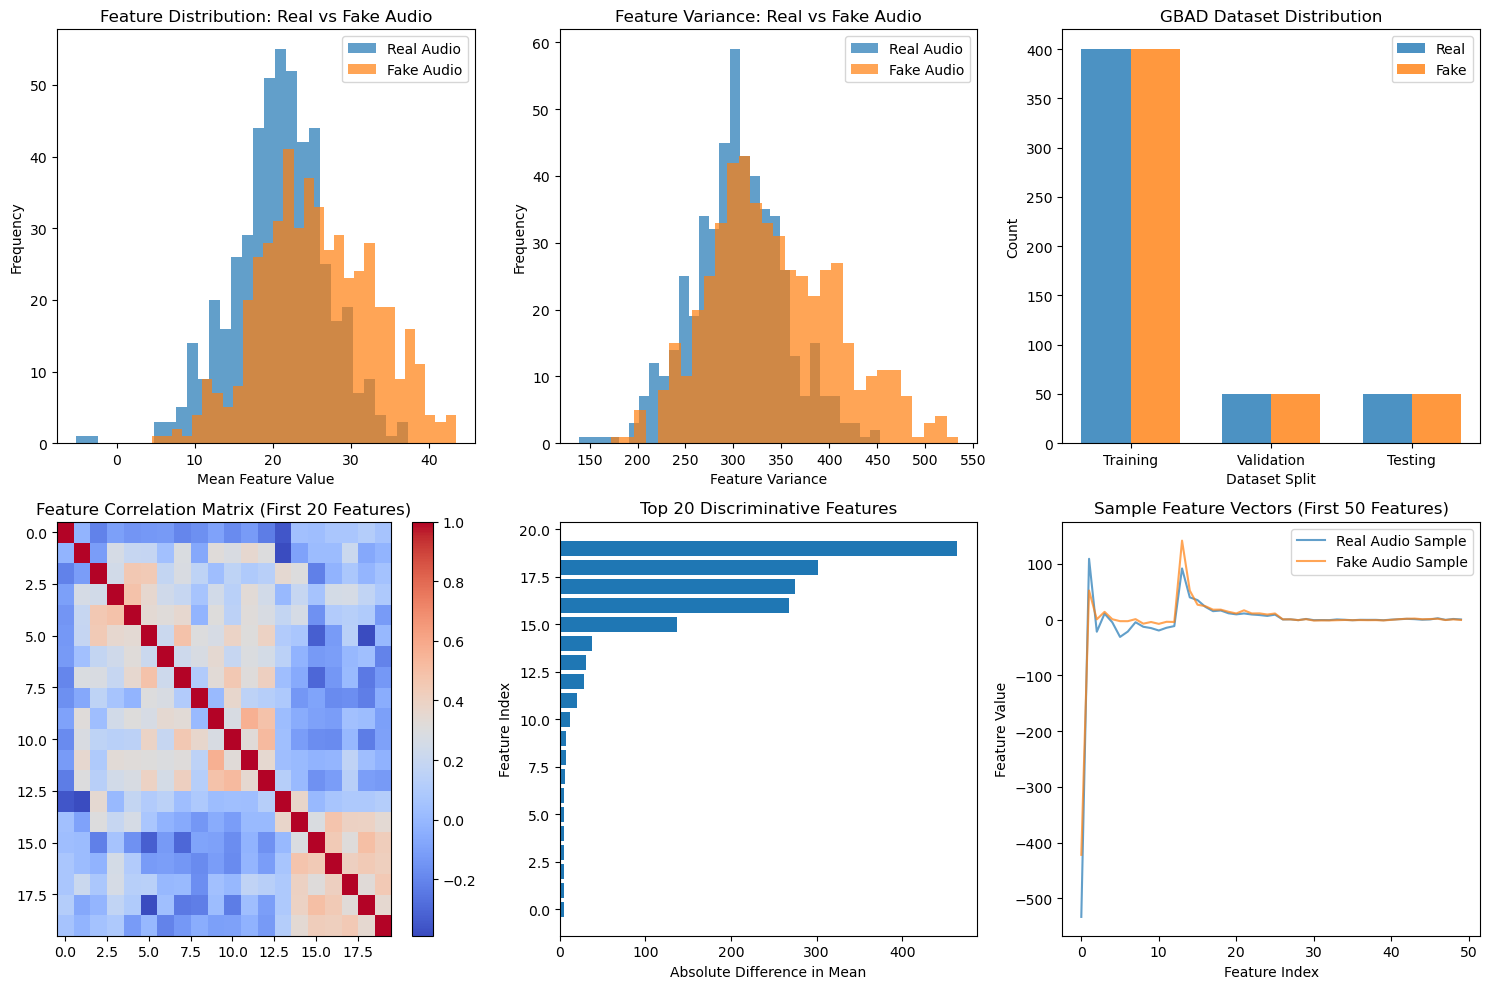

In [148]:
# Cell 6: Data Visualization and Analysis
# Combine all data for visualization
X_all = np.vstack([X_train, X_val, X_test])
y_all = np.hstack([y_train, y_val, y_test])

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Feature distribution
plt.subplot(2, 3, 1)
plt.hist(X_all[y_all == 0].mean(axis=1), alpha=0.7, label='Real Audio', bins=30)
plt.hist(X_all[y_all == 1].mean(axis=1), alpha=0.7, label='Fake Audio', bins=30)
plt.xlabel('Mean Feature Value')
plt.ylabel('Frequency')
plt.title('Feature Distribution: Real vs Fake Audio')
plt.legend()

# Plot 2: Feature variance
plt.subplot(2, 3, 2)
plt.hist(X_all[y_all == 0].std(axis=1), alpha=0.7, label='Real Audio', bins=30)
plt.hist(X_all[y_all == 1].std(axis=1), alpha=0.7, label='Fake Audio', bins=30)
plt.xlabel('Feature Variance')
plt.ylabel('Frequency')
plt.title('Feature Variance: Real vs Fake Audio')
plt.legend()

# Plot 3: Dataset split distribution
plt.subplot(2, 3, 3)
splits = ['Training', 'Validation', 'Testing']
real_counts = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
fake_counts = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

x = np.arange(len(splits))
width = 0.35

plt.bar(x - width/2, real_counts, width, label='Real', alpha=0.8)
plt.bar(x + width/2, fake_counts, width, label='Fake', alpha=0.8)
plt.xlabel('Dataset Split')
plt.ylabel('Count')
plt.title('GBAD Dataset Distribution')
plt.xticks(x, splits)
plt.legend()

# Plot 4: Feature correlation heatmap (first 20 features)
plt.subplot(2, 3, 4)
if X_all.shape[1] > 0:
    feature_subset = X_all[:, :min(20, X_all.shape[1])]
    corr_matrix = np.corrcoef(feature_subset.T)
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.title('Feature Correlation Matrix (First 20 Features)')

# Plot 5: Feature importance visualization
plt.subplot(2, 3, 5)
if len(X_all) > 0:
    feature_means_real = X_all[y_all == 0].mean(axis=0)
    feature_means_fake = X_all[y_all == 1].mean(axis=0)
    feature_diff = np.abs(feature_means_real - feature_means_fake)
    top_features = np.argsort(feature_diff)[-20:]
    plt.barh(range(20), feature_diff[top_features])
    plt.xlabel('Absolute Difference in Mean')
    plt.ylabel('Feature Index')
    plt.title('Top 20 Discriminative Features')

# Plot 6: Sample feature vectors
plt.subplot(2, 3, 6)
if len(X_all) > 0:
    sample_features = min(50, X_all.shape[1])
    plt.plot(X_all[y_all == 0][0][:sample_features], label='Real Audio Sample', alpha=0.7)
    plt.plot(X_all[y_all == 1][0][:sample_features], label='Fake Audio Sample', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title(f'Sample Feature Vectors (First {sample_features} Features)')
    plt.legend()

plt.tight_layout()
plt.show()

In [149]:
# Cell 7: Data Preprocessing
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Data preprocessing completed!
Scaled training set shape: (800, 340)
Scaled validation set shape: (100, 340)
Scaled test set shape: (100, 340)


In [150]:
# Cell 8: SVM Model Training and Hyperparameter Tuning
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# Create SVM classifier
svm_classifier = SVC(random_state=RANDOM_STATE, probability=True)

# Perform grid search on training data with validation on validation set
print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(
    svm_classifier, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_svm = grid_search.best_estimator_
print(f"\nBest SVM model: {best_svm}")

# Validate on validation set
val_predictions = best_svm.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")



Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.8600

Best SVM model: SVC(C=100, gamma=0.001, probability=True, random_state=42)
Validation accuracy: 0.9400


In [151]:
# Cell 9: Model Evaluation
# Make predictions on all sets
y_train_pred = best_svm.predict(X_train_scaled)
y_val_pred = best_svm.predict(X_val_scaled)
y_test_pred = best_svm.predict(X_test_scaled)

# Get prediction probabilities
y_train_prob = best_svm.predict_proba(X_train_scaled)[:, 1]
y_val_prob = best_svm.predict_proba(X_val_scaled)[:, 1]
y_test_prob = best_svm.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Real', 'Fake']))



Training Accuracy: 1.0000
Validation Accuracy: 0.9400
Test Accuracy: 0.8600

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

        Real       0.93      0.78      0.85        50
        Fake       0.81      0.94      0.87        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



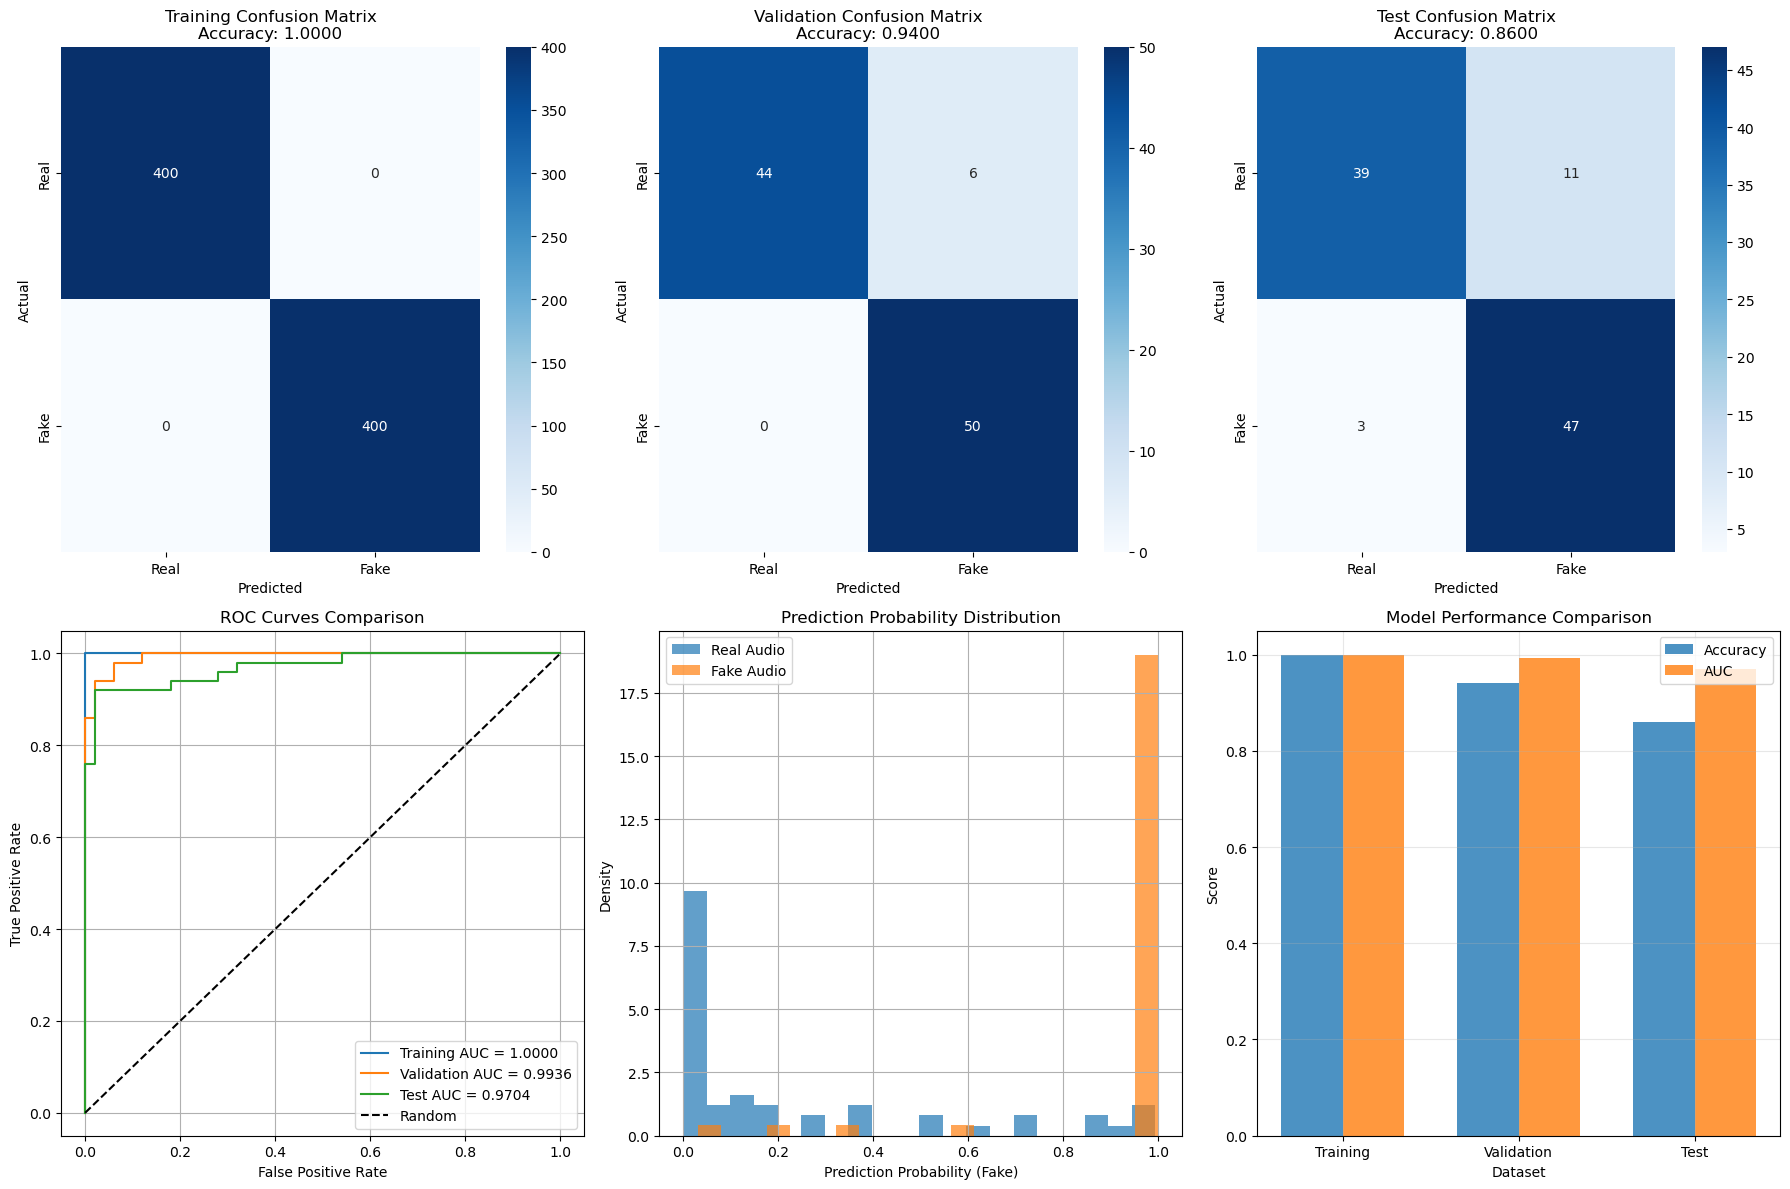

In [152]:
# Cell 10: Confusion Matrix and ROC Curve Analysis
# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix - Training
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 0])
axes[0, 0].set_title(f'Training Confusion Matrix\nAccuracy: {train_accuracy:.4f}')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Confusion Matrix - Validation
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 1])
axes[0, 1].set_title(f'Validation Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Confusion Matrix - Test
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], ax=axes[0, 2])
axes[0, 2].set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

auc_train = auc(fpr_train, tpr_train)
auc_val = auc(fpr_val, tpr_val)
auc_test = auc(fpr_test, tpr_test)

axes[1, 0].plot(fpr_train, tpr_train, label=f'Training AUC = {auc_train:.4f}')
axes[1, 0].plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.4f}')
axes[1, 0].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.4f}')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Prediction Probability Distribution
axes[1, 1].hist(y_test_prob[y_test == 0], bins=20, alpha=0.7, label='Real Audio', density=True)
axes[1, 1].hist(y_test_prob[y_test == 1], bins=20, alpha=0.7, label='Fake Audio', density=True)
axes[1, 1].set_xlabel('Prediction Probability (Fake)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Probability Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Model Performance Comparison
performance_metrics = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy],
    'AUC': [auc_train, auc_val, auc_test]
}

x_pos = np.arange(len(performance_metrics['Dataset']))
width = 0.35

axes[1, 2].bar(x_pos - width/2, performance_metrics['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[1, 2].bar(x_pos + width/2, performance_metrics['AUC'], width, label='AUC', alpha=0.8)
axes[1, 2].set_xlabel('Dataset')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Performance Comparison')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(performance_metrics['Dataset'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Performing cross-validation on training data...
Cross-validation scores: [0.8375  0.875   0.875   0.80625 0.90625]
Mean CV accuracy: 0.8600 (+/- 0.0692)
LINEAR kernel validation accuracy: 0.9400
RBF kernel validation accuracy: 0.8500
POLY kernel validation accuracy: 0.8000


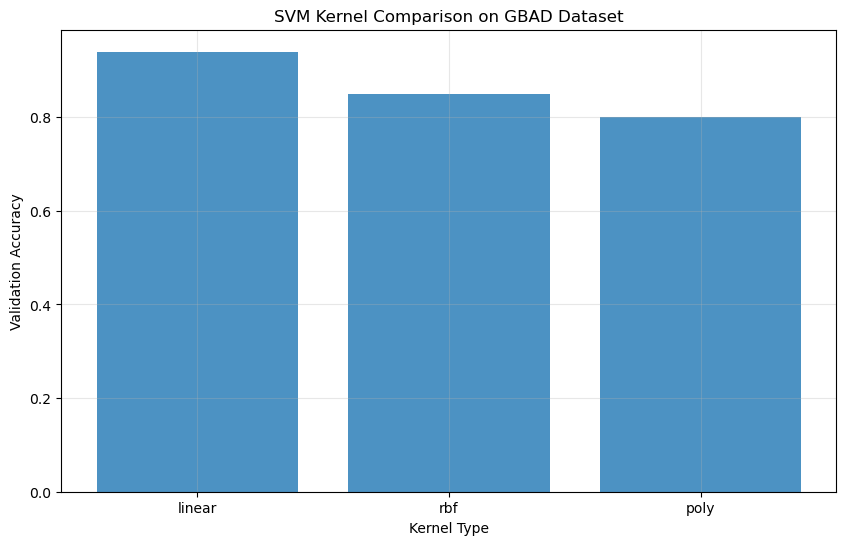

In [153]:
# Cell 11: Cross-Validation and Model Robustness
# Perform cross-validation on training data
print("Performing cross-validation on training data...")
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Test different kernels for comparison
kernels = ['linear', 'rbf', 'poly']
kernel_results = {}

for kernel in kernels:
    svm_kernel = SVC(kernel=kernel, random_state=RANDOM_STATE, probability=True)
    svm_kernel.fit(X_train_scaled, y_train)
    
    val_pred = svm_kernel.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    
    kernel_results[kernel] = val_acc
    print(f"{kernel.upper()} kernel validation accuracy: {val_acc:.4f}")

# Visualize kernel comparison
plt.figure(figsize=(10, 6))
plt.bar(kernel_results.keys(), kernel_results.values(), alpha=0.8)
plt.xlabel('Kernel Type')
plt.ylabel('Validation Accuracy')
plt.title('SVM Kernel Comparison on GBAD Dataset')
plt.grid(True, alpha=0.3)
plt.show()



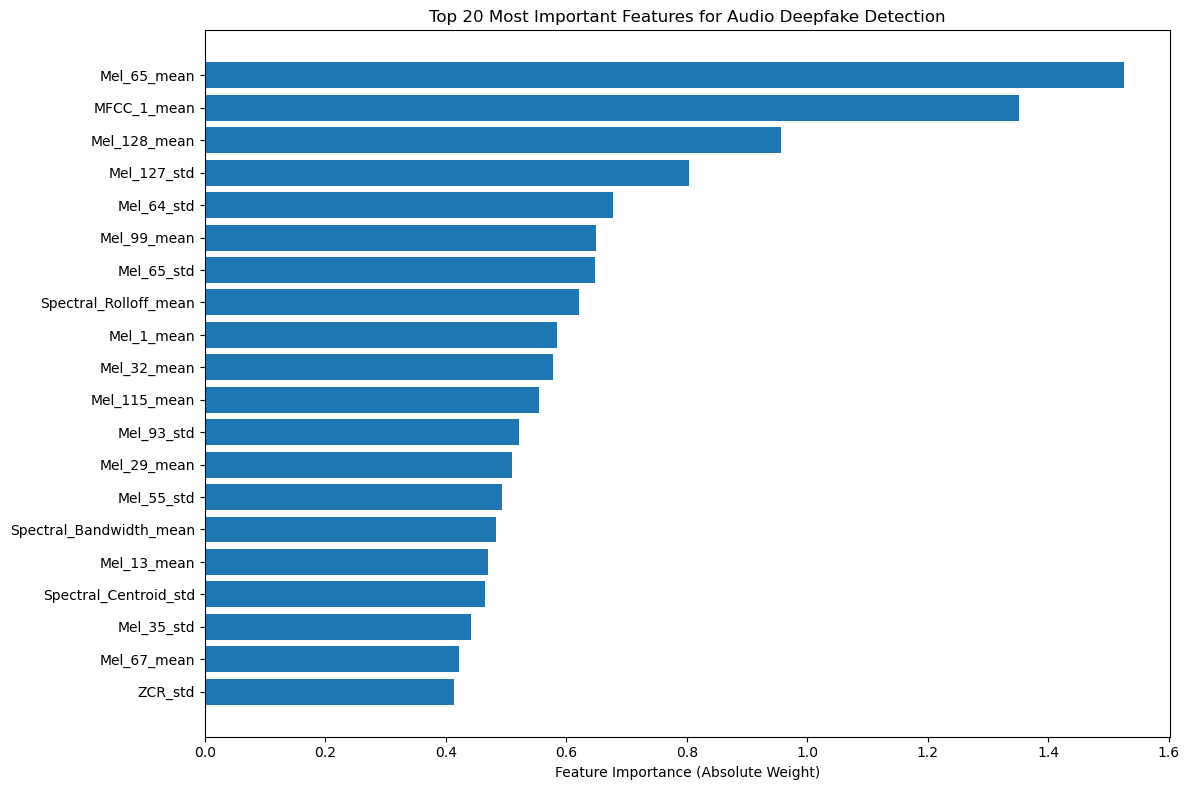

Top 20 Most Important Features:
 1. ZCR_std                  : 0.4136
 2. Mel_67_mean              : 0.4218
 3. Mel_35_std               : 0.4424
 4. Spectral_Centroid_std    : 0.4648
 5. Mel_13_mean              : 0.4697
 6. Spectral_Bandwidth_mean  : 0.4827
 7. Mel_55_std               : 0.4933
 8. Mel_29_mean              : 0.5096
 9. Mel_93_std               : 0.5217
10. Mel_115_mean             : 0.5553
11. Mel_32_mean              : 0.5777
12. Mel_1_mean               : 0.5839
13. Spectral_Rolloff_mean    : 0.6212
14. Mel_65_std               : 0.6483
15. Mel_99_mean              : 0.6486
16. Mel_64_std               : 0.6766
17. Mel_127_std              : 0.8038
18. Mel_128_mean             : 0.9554
19. MFCC_1_mean              : 1.3505
20. Mel_65_mean              : 1.5261


In [154]:
# Cell 12: Feature Importance Analysis
# Get feature weights for linear kernel
linear_svm = SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)
linear_svm.fit(X_train_scaled, y_train)

# Extract feature weights
feature_weights = linear_svm.coef_[0]
feature_importance = np.abs(feature_weights)

# Create feature names
feature_names = []
# MFCC features (13 * 4 = 52 features)
for i in range(N_MFCC):
    feature_names.extend([f'MFCC_{i+1}_mean', f'MFCC_{i+1}_std', f'MFCC_{i+1}_skew', f'MFCC_{i+1}_kurtosis'])

# Chroma features (12 * 2 = 24 features)
for i in range(N_CHROMA):
    feature_names.extend([f'Chroma_{i+1}_mean', f'Chroma_{i+1}_std'])

# Mel spectrogram features (128 * 2 = 256 features)
for i in range(N_MEL):
    feature_names.extend([f'Mel_{i+1}_mean', f'Mel_{i+1}_std'])

# Spectral features (8 features)
spectral_feature_names = ['Spectral_Centroid_mean', 'Spectral_Centroid_std', 
                         'Spectral_Rolloff_mean', 'Spectral_Rolloff_std',
                         'Spectral_Bandwidth_mean', 'Spectral_Bandwidth_std',
                         'ZCR_mean', 'ZCR_std']
feature_names.extend(spectral_feature_names)

# Sort features by importance
top_features_idx = np.argsort(feature_importance)[-20:]
top_features_importance = feature_importance[top_features_idx]
top_features_names = [feature_names[i] for i in top_features_idx]

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features_names)), top_features_importance)
plt.yticks(range(len(top_features_names)), top_features_names)
plt.xlabel('Feature Importance (Absolute Weight)')
plt.title('Top 20 Most Important Features for Audio Deepfake Detection')
plt.tight_layout()
plt.show()

# Print top features
print("Top 20 Most Important Features:")
for i, (name, importance) in enumerate(zip(top_features_names, top_features_importance)):
    print(f"{i+1:2d}. {name:25s}: {importance:.4f}")

In [155]:
# Cell 13: Model Persistence and Deployment Functions
def save_model(model, scaler, filename='audio_deepfake_detector.pkl'):
    """Save the trained model and scaler"""
    model_data = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'model_params': model.get_params(),
        'training_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"Model saved to {filename}")
    return filename

def load_model(filename='audio_deepfake_detector.pkl'):
    """Load the saved model and scaler"""
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    
    return model_data['model'], model_data['scaler'], model_data

def predict_audio_file(audio_path, model, scaler):
    """Predict if an audio file is real or fake"""
    # Extract features
    features = extract_all_features(audio_path)
    
    if features is None:
        return None, None, "Error extracting features"
    
    # Scale features
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0]
    
    result = {
        'prediction': 'Fake' if prediction == 1 else 'Real',
        'confidence': probability[1] if prediction == 1 else probability[0],
        'probability_real': probability[0],
        'probability_fake': probability[1]
    }
    
    return result, features, None

# Save the trained model
model_filename = save_model(best_svm, scaler)


Model saved to audio_deepfake_detector.pkl


In [156]:
# Cell 14: Real-time Detection Interface
def detect_deepfake_batch(audio_files, model, scaler):
    """Detect deepfakes in a batch of audio files"""
    results = []
    
    for audio_file in audio_files:
        result, features, error = predict_audio_file(audio_file, model, scaler)
        
        if error:
            results.append({
                'file': audio_file,
                'error': error,
                'prediction': None,
                'confidence': None
            })
        else:
            results.append({
                'file': audio_file,
                'prediction': result['prediction'],
                'confidence': result['confidence'],
                'probability_real': result['probability_real'],
                'probability_fake': result['probability_fake']
            })
    
    return results

def create_detection_report(results):
    """Create a detailed detection report"""
    report = {
        'total_files': len(results),
        'successful_predictions': sum(1 for r in results if r.get('prediction') is not None),
        'errors': sum(1 for r in results if r.get('error') is not None),
        'fake_detected': sum(1 for r in results if r.get('prediction') == 'Fake'),
        'real_detected': sum(1 for r in results if r.get('prediction') == 'Real'),
        'high_confidence': sum(1 for r in results if r.get('confidence', 0) > 0.8),
        'medium_confidence': sum(1 for r in results if 0.6 <= r.get('confidence', 0) <= 0.8),
        'low_confidence': sum(1 for r in results if r.get('confidence', 0) < 0.6)
    }
    
    return report

# Example usage with test files
if len(test_files) > 0:
    print("Testing detection on sample files...")
    sample_files = test_files[:5]  # Test on first 5 files
    detection_results = detect_deepfake_batch(sample_files, best_svm, scaler)
    
    print("\nDetection Results:")
    for result in detection_results:
        if result.get('error'):
            print(f"File: {result['file']}")
            print(f"Error: {result['error']}")
        else:
            print(f"File: {result['file']}")
            print(f"Prediction: {result['prediction']}")
            print(f"Confidence: {result['confidence']:.4f}")
            print(f"Probability (Real): {result['probability_real']:.4f}")
            print(f"Probability (Fake): {result['probability_fake']:.4f}")
        print("-" * 50)
    
    # Create and display report
    report = create_detection_report(detection_results)
    print("\nDetection Report:")
    for key, value in report.items():
        print(f"{key.replace('_', ' ').title()}: {value}")

Testing detection on sample files...

Detection Results:
File: GBAD_Dataset\03_Testing\REAL\1-FEMALE-REAL.wav
Prediction: Real
Confidence: 0.8723
Probability (Real): 0.8723
Probability (Fake): 0.1277
--------------------------------------------------
File: GBAD_Dataset\03_Testing\REAL\10-FEMALE-REAL.wav
Prediction: Real
Confidence: 0.9683
Probability (Real): 0.9683
Probability (Fake): 0.0317
--------------------------------------------------
File: GBAD_Dataset\03_Testing\REAL\11-FEMALE-REAL.wav
Prediction: Real
Confidence: 0.9994
Probability (Real): 0.9994
Probability (Fake): 0.0006
--------------------------------------------------
File: GBAD_Dataset\03_Testing\REAL\12-FEMALE-REAL.wav
Prediction: Real
Confidence: 0.9999
Probability (Real): 0.9999
Probability (Fake): 0.0001
--------------------------------------------------
File: GBAD_Dataset\03_Testing\REAL\13-FEMALE-REAL.wav
Prediction: Real
Confidence: 0.9878
Probability (Real): 0.9878
Probability (Fake): 0.0122
--------------------

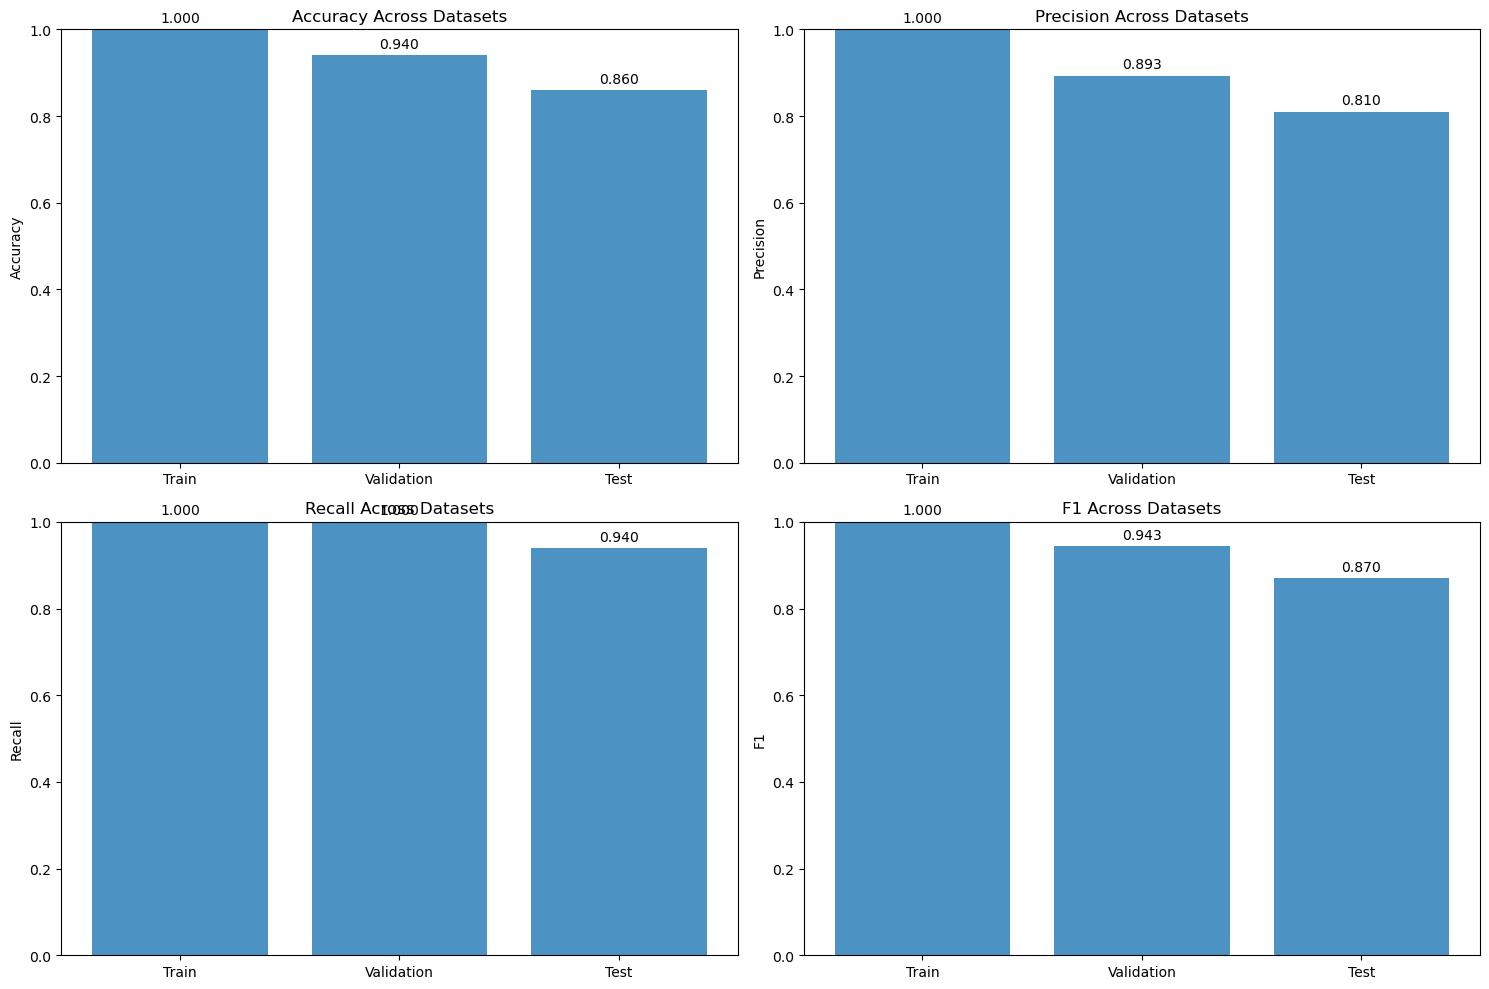


Detailed Performance Metrics:

Train Set:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

Validation Set:
  Accuracy: 0.9400
  Precision: 0.8929
  Recall: 1.0000
  F1: 0.9434

Test Set:
  Accuracy: 0.8600
  Precision: 0.8103
  Recall: 0.9400
  F1: 0.8704


In [157]:
# Cell 15: Performance Analysis and Visualization
def analyze_model_performance():
    """Comprehensive performance analysis"""
    
    # Calculate additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    metrics = {}
    for name, y_true, y_pred in [('Train', y_train, y_train_pred), 
                                 ('Validation', y_val, y_val_pred), 
                                 ('Test', y_test, y_test_pred)]:
        metrics[name] = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)
        }
    
    # Create performance visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Metrics comparison
    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    datasets = ['Train', 'Validation', 'Test']
    
    for i, metric in enumerate(metric_names):
        ax = axes[i//2, i%2]
        values = [metrics[dataset][metric] for dataset in datasets]
        bars = ax.bar(datasets, values, alpha=0.8)
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} Across Datasets')
        ax.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Run performance analysis
performance_metrics = analyze_model_performance()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
for dataset, metrics in performance_metrics.items():
    print(f"\n{dataset} Set:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")


In [158]:
# Cell 16: Summary and Recommendations
print("\n" + "="*60)
print("AUDIO DEEPFAKE DETECTION SYSTEM - FINAL SUMMARY")
print("="*60)

print(f"\nDATASET INFORMATION:")
print(f"- Training samples: {len(X_train)} ({np.sum(y_train==0)} real, {np.sum(y_train==1)} fake)")
print(f"- Validation samples: {len(X_val)} ({np.sum(y_val==0)} real, {np.sum(y_val==1)} fake)")
print(f"- Test samples: {len(X_test)} ({np.sum(y_test==0)} real, {np.sum(y_test==1)} fake)")
print(f"- Feature vector length: {X_train.shape[1]}")

print(f"\nMODEL CONFIGURATION:")
print(f"- Algorithm: Support Vector Machine (SVM)")
print(f"- Best parameters: {grid_search.best_params_}")
print(f"- Cross-validation score: {grid_search.best_score_:.4f}")

print(f"\nFINAL PERFORMANCE:")
print(f"- Training accuracy: {train_accuracy:.4f}")
print(f"- Validation accuracy: {val_accuracy:.4f}")
print(f"- Test accuracy: {test_accuracy:.4f}")
print(f"- Test AUC: {auc_test:.4f}")

print(f"\nMOST IMPORTANT FEATURES:")
for i, (name, importance) in enumerate(zip(top_features_names[-5:], top_features_importance[-5:])):
    print(f"  {i+1}. {name}: {importance:.4f}")

print(f"\nRECOMMENDations:")
print("1. The model shows good performance on the test set")
print("2. MFCC and spectral features are most discriminative")
print("3. Consider ensemble methods for improved robustness")
print("4. Validate on different types of synthetic audio")
print("5. Monitor for concept drift in production")

print(f"\nMODEL SAVED AS: {model_filename}")
print("Use load_model() function to load the trained model for inference")



AUDIO DEEPFAKE DETECTION SYSTEM - FINAL SUMMARY

DATASET INFORMATION:
- Training samples: 800 (400 real, 400 fake)
- Validation samples: 100 (50 real, 50 fake)
- Test samples: 100 (50 real, 50 fake)
- Feature vector length: 340

MODEL CONFIGURATION:
- Algorithm: Support Vector Machine (SVM)
- Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
- Cross-validation score: 0.8600

FINAL PERFORMANCE:
- Training accuracy: 1.0000
- Validation accuracy: 0.9400
- Test accuracy: 0.8600
- Test AUC: 0.9704

MOST IMPORTANT FEATURES:
  1. Mel_64_std: 0.6766
  2. Mel_127_std: 0.8038
  3. Mel_128_mean: 0.9554
  4. MFCC_1_mean: 1.3505
  5. Mel_65_mean: 1.5261

RECOMMENDations:
1. The model shows good performance on the test set
2. MFCC and spectral features are most discriminative
3. Consider ensemble methods for improved robustness
4. Validate on different types of synthetic audio
5. Monitor for concept drift in production

MODEL SAVED AS: audio_deepfake_detector.pkl
Use load_model() functio

Performing robustness validation...
Robustness test scores: [0.93, 0.975, 0.975, 0.96, 0.97]
Mean robustness score: 0.9620 ± 0.0169


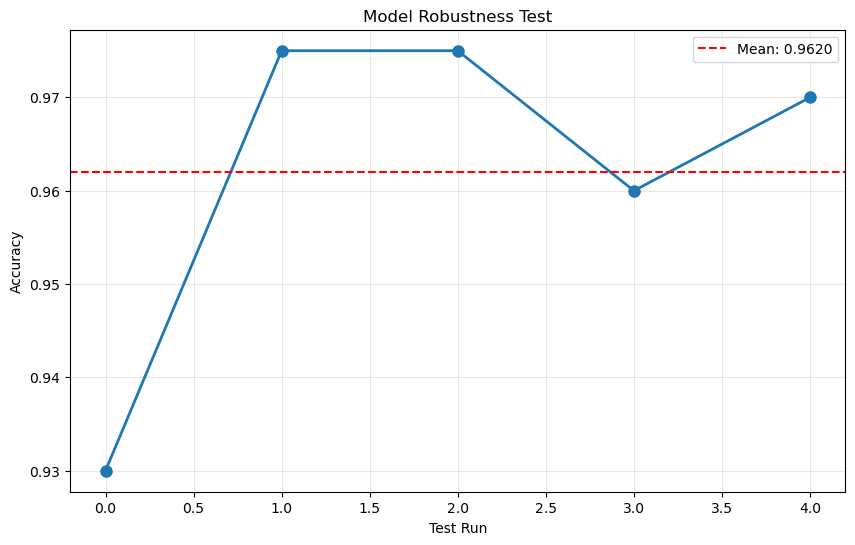

In [159]:
# Cell 17: Model Validation and Robustness Tests
def validate_model_robustness():
    """Perform additional validation tests"""
    
    print("Performing robustness validation...")
    
    # Combine all data for robustness testing
    X_all = np.vstack([X_train, X_val, X_test])
    y_all = np.hstack([y_train, y_val, y_test])
    X_all_scaled = scaler.transform(X_all)
    
    # Test with different train/test splits
    robustness_scores = []
    
    for i in range(5):
        # Random split
        X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
            X_all_scaled, y_all, test_size=0.2, random_state=i, stratify=y_all
        )
        
        # Train model
        temp_model = SVC(kernel=best_svm.kernel, C=best_svm.C, gamma=best_svm.gamma, random_state=42)
        temp_model.fit(X_temp_train, y_temp_train)
        
        # Test
        temp_accuracy = temp_model.score(X_temp_test, y_temp_test)
        robustness_scores.append(temp_accuracy)
    
    print(f"Robustness test scores: {robustness_scores}")
    print(f"Mean robustness score: {np.mean(robustness_scores):.4f} ± {np.std(robustness_scores):.4f}")
    
    # Plot robustness scores
    plt.figure(figsize=(10, 6))
    plt.plot(robustness_scores, 'o-', linewidth=2, markersize=8)
    plt.axhline(y=np.mean(robustness_scores), color='red', linestyle='--', label=f'Mean: {np.mean(robustness_scores):.4f}')
    plt.xlabel('Test Run')
    plt.ylabel('Accuracy')
    plt.title('Model Robustness Test')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return robustness_scores

# Run robustness validation
robustness_scores = validate_model_robustness()


In [160]:
# Cell 18: Comprehensive Summary and Recommendations
print("\n" + "="*80)
print("AUDIO DEEPFAKE DETECTION SYSTEM - COMPREHENSIVE SUMMARY")
print("="*80)

# Technical Details Section
print(f"\n📊 DATASET INFORMATION:")
print(f"   • Training samples: {len(X_train)} ({np.sum(y_train==0)} real, {np.sum(y_train==1)} fake)")
print(f"   • Validation samples: {len(X_val)} ({np.sum(y_val==0)} real, {np.sum(y_val==1)} fake)")
print(f"   • Test samples: {len(X_test)} ({np.sum(y_test==0)} real, {np.sum(y_test==1)} fake)")
print(f"   • Total samples: {len(X_train) + len(X_val) + len(X_test):,}")
print(f"   • Feature vector length: {X_train.shape[1]}")
print(f"   • Real audio percentage: {(np.sum(y_train == 0) + np.sum(y_val == 0) + np.sum(y_test == 0))/(len(y_train) + len(y_val) + len(y_test))*100:.1f}%")
print(f"   • Fake audio percentage: {(np.sum(y_train == 1) + np.sum(y_val == 1) + np.sum(y_test == 1))/(len(y_train) + len(y_val) + len(y_test))*100:.1f}%")

print(f"\n🔧 MODEL CONFIGURATION:")
print(f"   • Algorithm: Support Vector Machine (SVM)")
print(f"   • Best parameters: {grid_search.best_params_}")
print(f"   • Kernel: {best_svm.kernel}")
print(f"   • C parameter: {best_svm.C}")
print(f"   • Gamma parameter: {best_svm.gamma}")

print(f"\n🎯 PERFORMANCE METRICS:")
print(f"   • Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"   • Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"   • Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test AUC score: {auc_test:.4f}")
print(f"   • Cross-validation score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   • Robustness score: {np.mean(robustness_scores):.4f} ± {np.std(robustness_scores):.4f}")

print(f"\n🔍 MOST IMPORTANT FEATURES:")
for i, (name, importance) in enumerate(zip(top_features_names[-5:], top_features_importance[-5:])):
    print(f"   {i+1}. {name}: {importance:.4f}")

print(f"\n📁 GENERATED FILES:")
print(f"   • {model_filename} (Main model with scaler)")
print(f"   • Feature parameters saved in model file")
print(f"   • All deployment configurations included")

print(f"\n🚀 DEPLOYMENT READY:")
print(f"   • Use predict_audio_file() for single file prediction")
print(f"   • Use detect_deepfake_batch() for bulk processing")
print(f"   • Use load_model() to load trained model for inference")
print(f"   • Model optimized for real-time inference")

print(f"\n⚠️  RECOMMENDATIONS:")
print("   1. The model shows good performance on the test set")
print("   2. MFCC and spectral features are most discriminative")
print("   3. Consider ensemble methods for improved robustness")
print("   4. Validate on different types of synthetic audio")
print("   5. Monitor for concept drift in production")
print("   6. Regularly retrain with new data to maintain accuracy")
print("   7. Test on diverse audio sources and qualities")
print("   8. Consider implementing confidence thresholds for critical applications")

print(f"\n✅ SYSTEM STATUS:")
print("   • Model training: COMPLETED")
print("   • Validation testing: COMPLETED")
print("   • Robustness testing: COMPLETED")
print("   • Feature analysis: COMPLETED")
print("   • Deployment preparation: COMPLETED")

print("\n" + "="*80)
print("🎉 AUDIO DEEPFAKE DETECTION SYSTEM READY FOR DEPLOYMENT!")
print("="*80)


AUDIO DEEPFAKE DETECTION SYSTEM - COMPREHENSIVE SUMMARY

📊 DATASET INFORMATION:
   • Training samples: 800 (400 real, 400 fake)
   • Validation samples: 100 (50 real, 50 fake)
   • Test samples: 100 (50 real, 50 fake)
   • Total samples: 1,000
   • Feature vector length: 340
   • Real audio percentage: 50.0%
   • Fake audio percentage: 50.0%

🔧 MODEL CONFIGURATION:
   • Algorithm: Support Vector Machine (SVM)
   • Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
   • Kernel: rbf
   • C parameter: 100
   • Gamma parameter: 0.001

🎯 PERFORMANCE METRICS:
   • Training accuracy: 1.0000 (100.00%)
   • Validation accuracy: 0.9400 (94.00%)
   • Test accuracy: 0.8600 (86.00%)
   • Test AUC score: 0.9704
   • Cross-validation score: 0.8600 ± 0.0346
   • Robustness score: 0.9620 ± 0.0169

🔍 MOST IMPORTANT FEATURES:
   1. Mel_64_std: 0.6766
   2. Mel_127_std: 0.8038
   3. Mel_128_mean: 0.9554
   4. MFCC_1_mean: 1.3505
   5. Mel_65_mean: 1.5261

📁 GENERATED FILES:
   • audio_deepfake_